In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
from dataset import Data, ResizeTransform
from gan import GeneratorNet, Discriminator, train
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
from visualize import plot_batch, PlotLossCallback

%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [2]:
DATA_PATH = 'data/img_align_celeba'
BATCH_SIZE = 16
NUM_WORKERS = 2
Z_SIZE = 16
transform = ResizeTransform()
data = Data(DATA_PATH, Z_SIZE, transform)
data_loader = DataLoader(data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, drop_last=True)

In [3]:
generator = GeneratorNet(Z_SIZE).cuda()
discriminator = Discriminator().cuda()

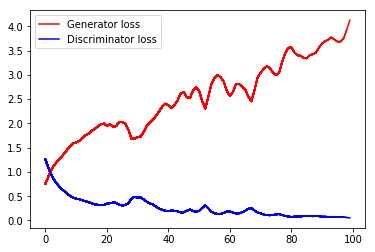

In [4]:
callback = PlotLossCallback()
train(generator, discriminator, data_loader, 100, k=2, callback_func=callback)


In [ ]:
Z = torch.normal(mean=torch.zeros(4, generator.z_size)).cuda()
G_sample = generator(Z)
print(Z)

In [ ]:
for batch, Z in data_loader:
    plot_batch(batch.data.cpu().numpy())
    break

In [ ]:
plot_batch(G_sample.data.cpu().numpy())

In [ ]:
w = generator.layer3[0].weight.data.cpu().numpy()
print(w)

In [ ]:
for batch, Z in data_loader:
    X = batch.cuda()
    Z = Z.cuda()
    G_sample = generator(Z)
    D_real, D_logit_real = discriminator(X)
    D_fake, D_logit_fake = discriminator(G_sample)
    print('D_real', D_real,'\n', 'D_fake', D_fake)
    print('D_logit_real', D_logit_real, '\n', 'D_logit_fake', D_logit_fake)
    break
    